## <font color='darkred'> Inteligência Artificial em Finanças </font>
    
### <font color='darkgreen'>Lab 1 - Parte 1 - Método Naive e Exponential Smoothing</font>

### <font color='darkblue'>Forecast de títulos de Renda Fixa ao longo do tempo</font>



### <font color='darkblue'>Instalando e Carregando Pacotes</font>

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.13


In [2]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
# !pip install -q -U watermark

In [3]:
# Imports para manipulação de dados
import numpy as np
import pandas as pd
from datetime import datetime

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
from matplotlib.pyplot import figure

# Imports para métricas e performance do modelo
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Imports para modelagem preditiva - parte2
import statsmodels
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Filtrando FutureWarning
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore")

In [4]:
# Formatando as saídas dos gráficos
plt.style.use('fivethirtyeight')
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
m.rcParams['axes.labelsize'] = 12
m.rcParams['xtick.labelsize'] = 10
m.rcParams['ytick.labelsize'] = 10
m.rcParams['text.color'] = 'k'

In [5]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Michelle Bouhid" --iversions

Author: Michelle Bouhid

statsmodels: 0.14.0
numpy      : 1.23.5
platform   : 1.0.8
sklearn    : 1.3.0
matplotlib : 3.7.1
pandas     : 1.5.3



### <font color='darkblue'>Carregando e Compreendendo Dados</font>

In [6]:
# Carrega os dados
dados_treino = pd.read_csv("dados/dataset_treino.csv")
dados_teste = pd.read_csv("dados/dataset_teste.csv")

In [7]:
# Shape
dados_treino.shape

(18288, 3)

In [8]:
# Primeiros registros
dados_treino.head()

,id,data,valor_titulo
0,0,25-08-2020 00:00,8
1,1,25-08-2020 01:00,2
2,2,25-08-2020 02:00,6
3,3,25-08-2020 03:00,2
4,4,25-08-2020 04:00,2


In [9]:
# Ultimos registros
dados_treino.tail()

,id,data,valor_titulo
18283,18283,25-09-2022 19:00,868
18284,18284,25-09-2022 20:00,732
18285,18285,25-09-2022 21:00,702
18286,18286,25-09-2022 22:00,580
18287,18287,25-09-2022 23:00,534


In [10]:
# Tipos de dados
dados_treino.dtypes

id               int64
data            object
valor_titulo     int64
dtype: object

In [11]:
# Tipo do objeto
type(dados_treino)

pandas.core.frame.DataFrame

### <font color='darkblue'>Exploração e Visualização do Comportamento dos Dados ao Longo do Tempo</font>

Vamos fazer algumas transformações nos dados para poder criar alguns gráficos e verificar se temos algum padrão disponível.

In [12]:
# Converte a coluna de data para o tipo correto - treino
dados_treino['data'] = pd.to_datetime(dados_treino.data, format = '%d-%m-%Y %H:%M')

In [13]:
# Verifica os tipos de dados
dados_treino.dtypes

id                       int64
data            datetime64[ns]
valor_titulo             int64
dtype: object

In [14]:
# Converte a coluna de data para o tipo correto - teste
dados_teste['data'] = pd.to_datetime(dados_teste.data, format = '%d-%m-%Y %H:%M')

In [15]:
# Verifica os tipos de dados
dados_teste.dtypes

id               int64
data    datetime64[ns]
dtype: object

In [16]:
# Vamos extrair os detalhes da coluna de data: ano, mês, dia e hora
for i in (dados_treino, dados_teste):
    i['ano'] = i.data.dt.year
    i['mes'] = i.data.dt.month
    i['dia'] = i.data.dt.day
    i['hora'] = i.data.dt.hour

In [17]:
# Precisamos do dia da semana também
dados_treino['dia_semana'] = dados_treino['data'].dt.dayofweek

In [18]:
# Vejamos como ficou o dataset
dados_treino.head(10)

,id,data,valor_titulo,ano,mes,dia,hora,dia_semana
0,0,2020-08-25 00:00:00,8,2020,8,25,0,1
1,1,2020-08-25 01:00:00,2,2020,8,25,1,1
2,2,2020-08-25 02:00:00,6,2020,8,25,2,1
3,3,2020-08-25 03:00:00,2,2020,8,25,3,1
4,4,2020-08-25 04:00:00,2,2020,8,25,4,1
5,5,2020-08-25 05:00:00,2,2020,8,25,5,1
6,6,2020-08-25 06:00:00,2,2020,8,25,6,1
7,7,2020-08-25 07:00:00,2,2020,8,25,7,1
8,8,2020-08-25 08:00:00,6,2020,8,25,8,1
9,9,2020-08-25 09:00:00,2,2020,8,25,9,1


In [19]:
# Refinamos os dados para o gráfico

# Definimos o índice do dataset
dados_treino.index = dados_treino['data']

# Removemos a coluna ID, pois ela não é relevante neste caso
features = dados_treino.drop('id', axis = 1)

# A variável Count é nossa variável target (total de pessoas que usaram transporte)
target = dados_treino['valor_titulo']

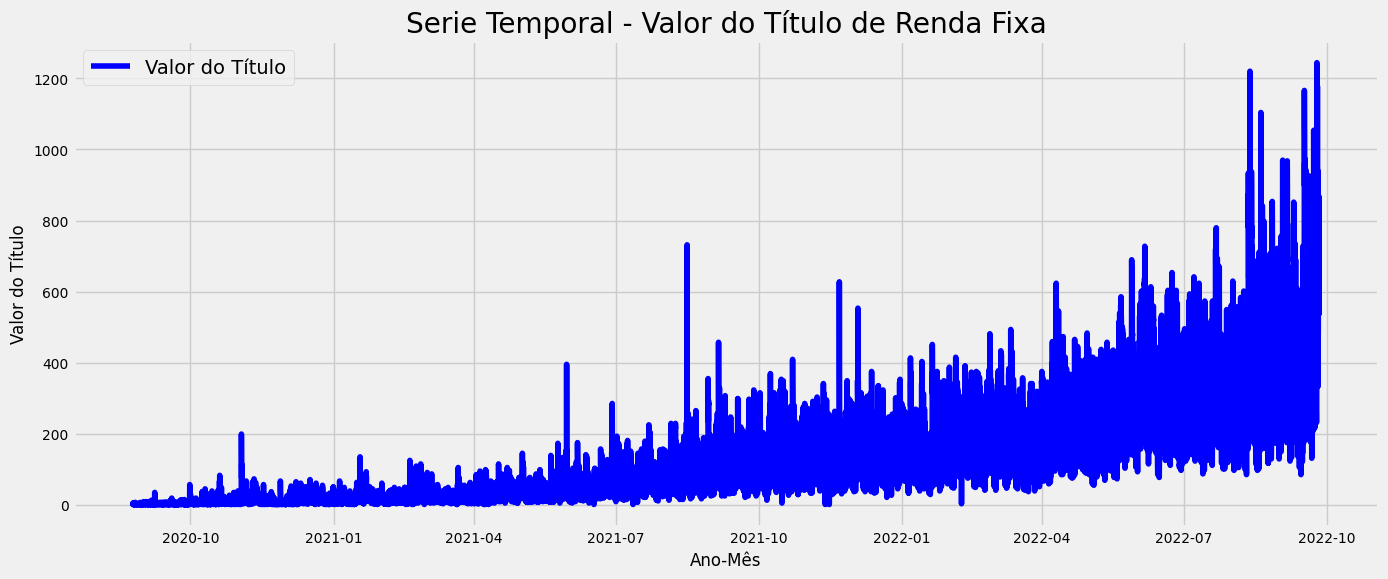

In [20]:
# Plot
figure(figsize = (15, 6))
plt.title("Serie Temporal - Valor do Título de Renda Fixa")
plt.plot(target, label = "Valor do Título", color = 'blue')
plt.xlabel("Ano-Mês")
plt.ylabel("Valor do Título")
plt.legend(loc = "best")

Percebemos que há claramente uma tendência de aumento no valor do título ao longo do tempo. Vamos extrair mais detalhes com outros graficos.

Observe que calcularemos as médias abaixo sem considerar ordem cronológica. Cada elemento de data é tratado como uma categoria.

<Axes: xlabel='ano'>

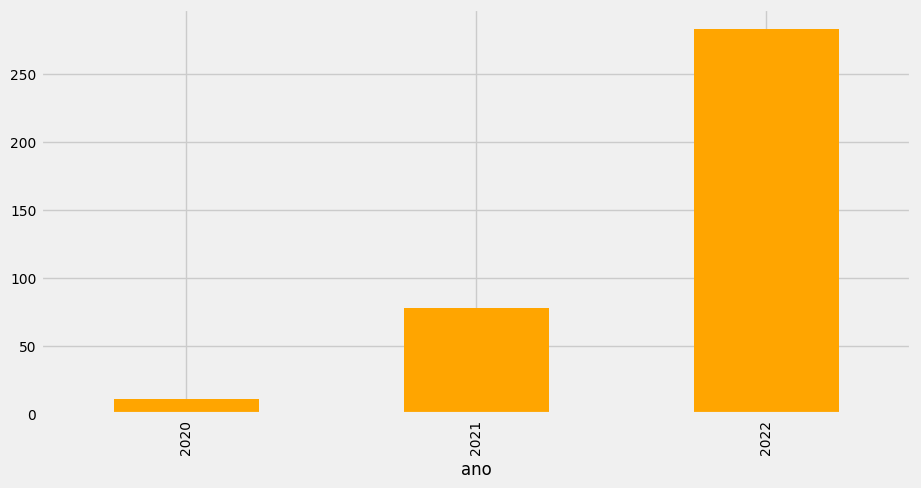

In [21]:
# Vamos criar um gráfico de barras com a média do valor do título por ano
figure(figsize = (10, 5))
dados_treino.groupby('ano')['valor_titulo'].mean().plot.bar(color = 'orange')

<Axes: xlabel='mes'>

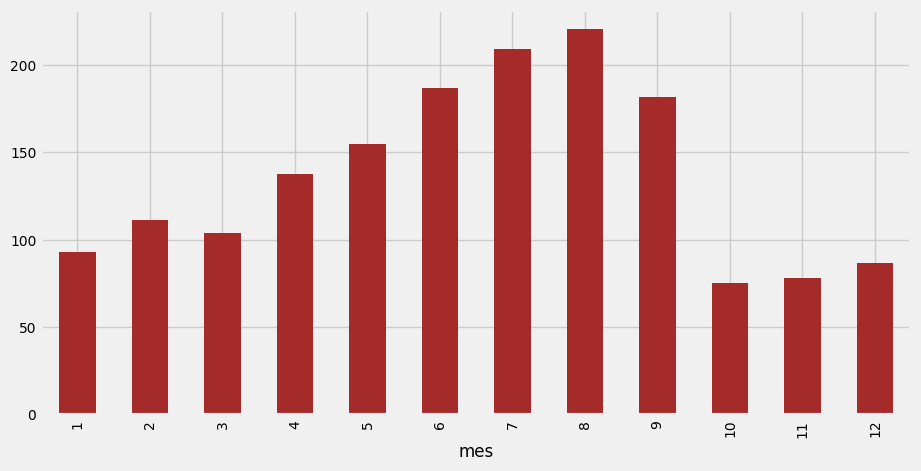

In [22]:
# Vamos criar um gráfico de barras com a média do valor do título por mês (independente do ano)
figure(figsize = (10, 5))
dados_treino.groupby('mes')['valor_titulo'].mean().plot.bar(color = 'brown')

<Axes: title={'center': 'Média do Valor do Título Por Mês a Cada Ano'}, xlabel='ano,mes'>

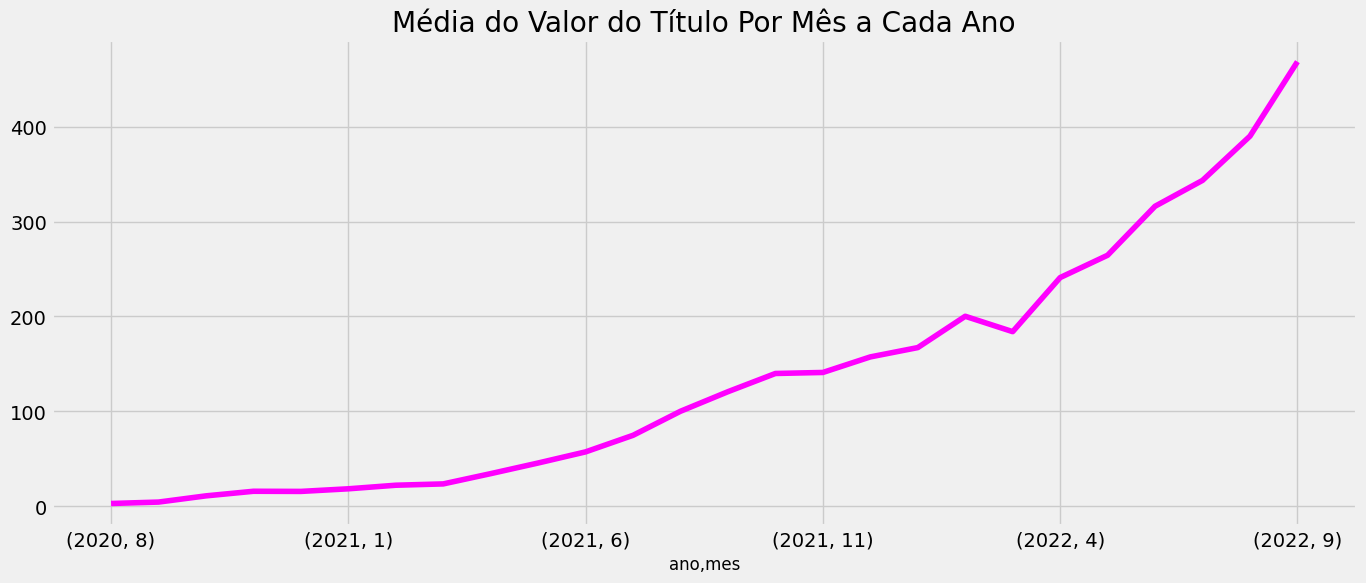

In [23]:
# Vamos calcular a média mensal por ano_mês
figure(figsize = (15, 6))
media_mensal = dados_treino.groupby(['ano', 'mes'])['valor_titulo'].mean()
media_mensal.plot(title = "Média do Valor do Título Por Mês a Cada Ano", fontsize = 14, color = 'magenta')

<Axes: xlabel='dia'>

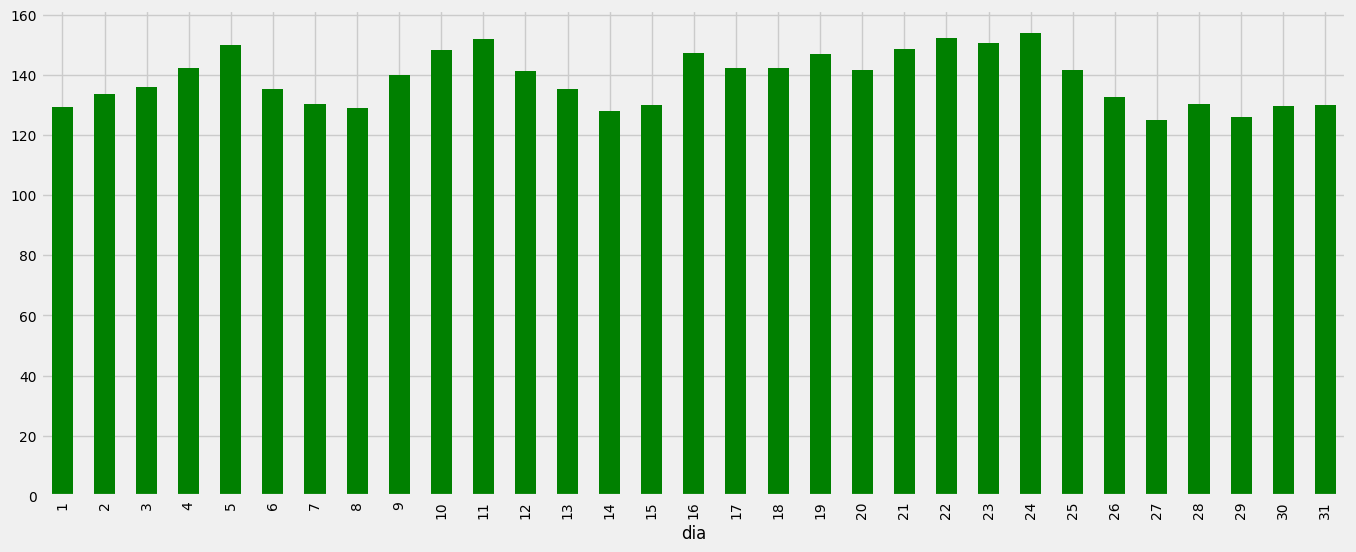

In [24]:
# E qual será a média diária por dia do mês? Vamos checar
figure(figsize = (15, 6))
dados_treino.groupby('dia')['valor_titulo'].mean().plot.bar(color = 'green')

<Axes: xlabel='hora'>

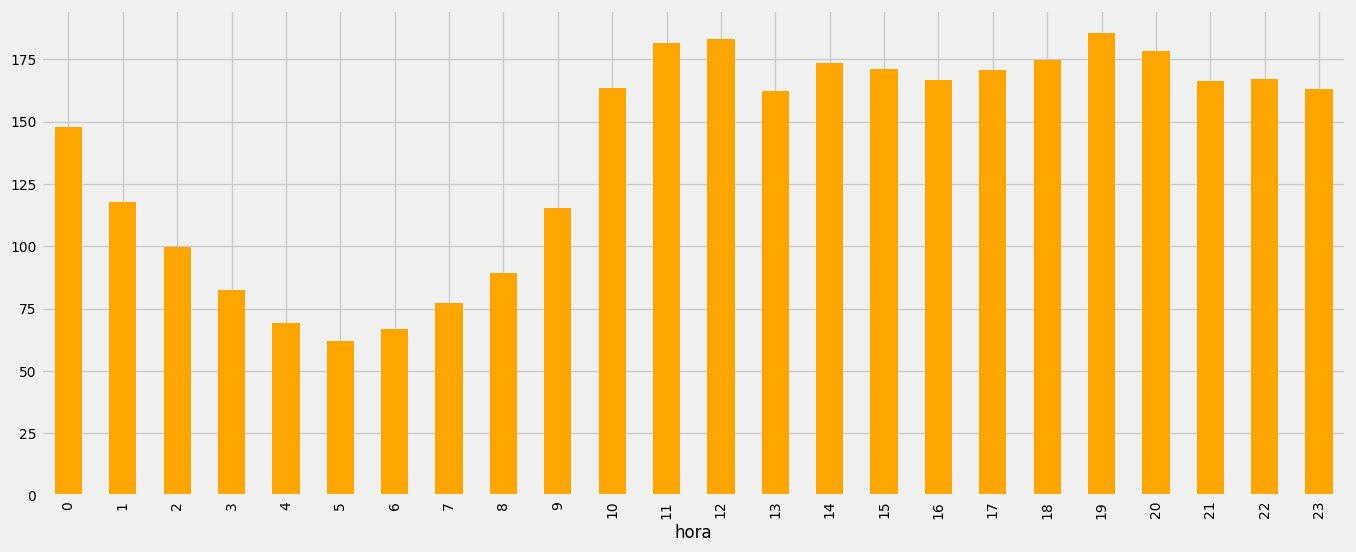

In [25]:
# Vamos descer mais um nível e analisar a média por hora
# Como era de se esperar, na madrugada a média é menor do que em outras horas do dia
figure(figsize = (15, 6))
dados_treino.groupby('hora')['valor_titulo'].mean().plot.bar(color = 'orange')

Vamos criar um gráfico com 4 séries representando a média por mês, por semana, por dia e por hora para confirmar a tendência de crescimento. 

Observe que agora calcularemos as médias abaixo considerando a ordem cronológica dos dados.

In [26]:
dados_treino.tail()

,id,data,valor_titulo,ano,mes,dia,hora,dia_semana
data,,,,,,,,
2022-09-25 19:00:00,18283,2022-09-25 19:00:00,868,2022,9,25,19,6
2022-09-25 20:00:00,18284,2022-09-25 20:00:00,732,2022,9,25,20,6
2022-09-25 21:00:00,18285,2022-09-25 21:00:00,702,2022,9,25,21,6
2022-09-25 22:00:00,18286,2022-09-25 22:00:00,580,2022,9,25,22,6
2022-09-25 23:00:00,18287,2022-09-25 23:00:00,534,2022,9,25,23,6


https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html

In [27]:
# Média por mês
serie_media_mes = dados_treino.resample('M').mean()

In [28]:
# Média por semana
serie_media_semana = dados_treino.resample('W').mean()

In [29]:
# Média por dia
serie_media_dia = dados_treino.resample('D').mean() 

In [30]:
# Média por hora
serie_media_hora = dados_treino.resample('H').mean() 

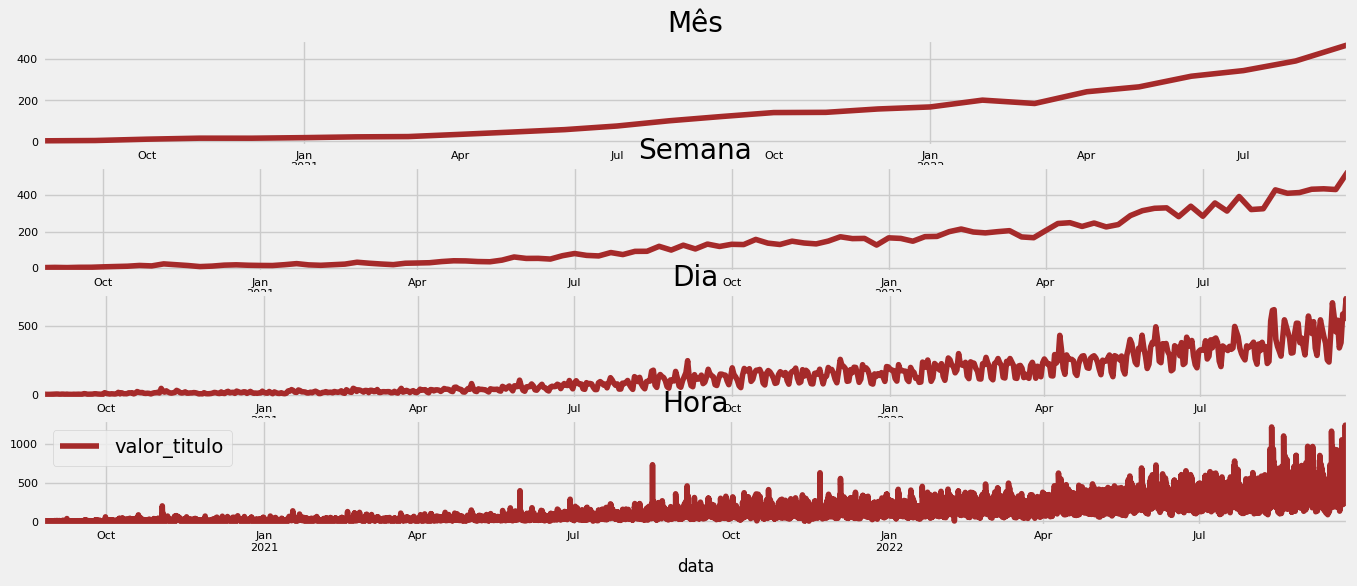

In [31]:
# Plot
fig, axs = plt.subplots(4,1) 
serie_media_mes.valor_titulo.plot(title = 'Mês', fontsize = 8, ax = axs[0], color = 'brown', figsize = (15, 6)) 
serie_media_semana.valor_titulo.plot(title = 'Semana', fontsize = 8, ax = axs[1], color = 'brown', figsize = (15, 6)) 
serie_media_dia.valor_titulo.plot(title = 'Dia', fontsize = 8, ax = axs[2], color = 'brown', figsize = (15, 6)) 
serie_media_hora.valor_titulo.plot(title = 'Hora', fontsize = 8, ax = axs[3], color = 'brown', figsize = (15, 6)) 
plt.legend(loc = "best")
plt.show()

### <font color='darkblue'>Exploração e Visualização do Comportamento dos Dados ao Longo do Tempo</font>

Já coletamos bastante informação sobre nossos dados. Essa compreensão ajuda a entender se nosso modelo preditivo será eficiente. 

Vamos agora dividir os dados de treino em duas amostras, treino e validação. Usamos os dados de treino para treinar o modelo e os dados de validação para validar a performance do modelo antes de usar dados de teste.

Observe que os registros são separados em ordem cronológica, diferentemente o que fazemos com modelos de Machine Learning que não consideram a data como indexador. Para esses modelos queremos a divisão dos dados de forma aleatória. Em séries temporais, queremos a divisão em ordem cronológica, já que o tempo é um elemento de informação dos dados.

Não precisamos checar a estacionaridade da série, pois o primeiro método de Forecasting usado não faz suposições sobre a série temporal.

In [32]:
# Os dados de treino serão divididos em dados de treino e validação
# trabalhando com ML, sem ser em Série Temporal a divisão deve ser aleatória
# Em Serie Temporal não pode perder a ordem cronológica, porque a ordem faz parte da informação
df_treino = dados_treino.iloc[0:16057] #mantendo a cronologia
df_valid = dados_treino.iloc[16058:]

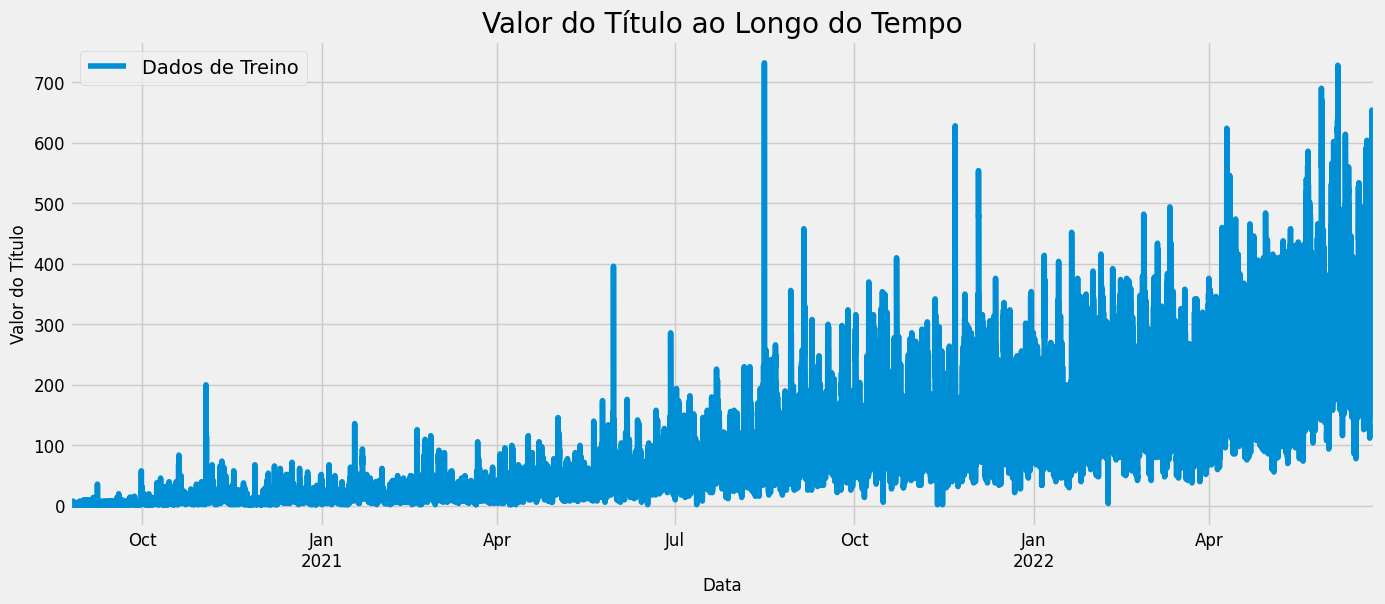

In [33]:
# Plot
figure(figsize = (15, 6))
df_treino.valor_titulo.plot(title = 'Valor do Título ao Longo do Tempo', fontsize = 12, label = 'Dados de Treino') 
plt.xlabel("Data") 
plt.ylabel("Valor do Título") 
plt.legend(loc = 'best') 
plt.show()

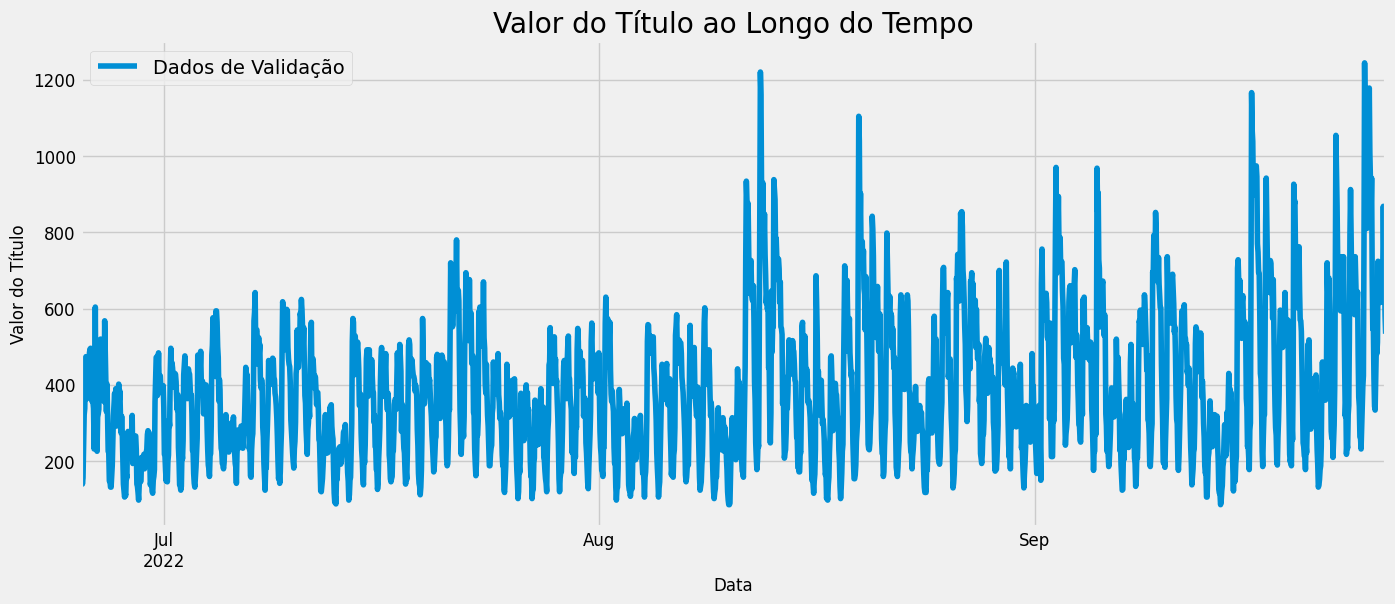

In [34]:
# Plot
# apesar de parecer diferente, o padrao é o mesmo do acima, mas a janela é diferente
# num total de 18288, temos apenas 2.200 e poucos dados, enquanto treino tem 16 mil +-
df_valid.valor_titulo.plot(title = 'Valor do Título ao Longo do Tempo', fontsize = 12, label = 'Dados de Validação') 
plt.xlabel("Data") 
plt.ylabel("Valor do Título") 
plt.legend(loc = 'best') 
plt.show()

### <font color='darkblue'>Forecasting - Modelagem Preditiva Para Séries Temporais</font>

Criaremos vários modelos para este problema que temos em mãos, aumentando o grau de complexidade a cada versão.

Mas toda caminhada deve começar com o primeiro passo. Vamos começar com o modelo preditivo mais simples que podemos criar.

### <font color = darkred> Implementando a Estratégia 1 de Forecasting - Método Naive </font>

No contexto de séries temporais, o método Naive é uma técnica muito simples de previsão. Ele assume que o valor da previsão para o próximo período será igual ao último valor observado. Por exemplo, se você está prevendo valores diários, o valor de hoje é usado como previsão para amanhã. É uma abordagem básica que não leva em conta tendências, sazonalidade ou outros fatores, e é usada como um ponto de partida ou benchmark para avaliar modelos mais complexos.

Naive = ingênuo

Não há técnica avançada aqui e apenas usamos como ponto de partida. Qualquer modelo mais avançado deve apresentar resultados superiores ao Método Naive.



In [35]:
type(df_treino)

pandas.core.frame.DataFrame

In [36]:
# Criamos um array com os valores da variável target em treino
array_valor_titulo_treino = np.asarray(df_treino.valor_titulo)

In [37]:
type(array_valor_titulo_treino)

numpy.ndarray

In [38]:
array_valor_titulo_treino

array([  8,   2,   6, ..., 352, 390, 332], dtype=int64)

In [39]:
# Cria uma cópia dos dados de validação para usar na comparação dos dados reais com as previsões
# vamos usar depois pra calcular o erro do modelo
df_valid_cp = df_valid.copy()

Veja como o método é mesmo Naive

Os dados reais (de treino) são usados como previsão para os dados de validação, sem ajustá-los ou tentar estabelecer fatores causais.

In [40]:
len(array_valor_titulo_treino)

16057

In [41]:
# Pega o ultimo valor do array e usa como previsão para os proximos valores da serie
# pega o comprimento e subtrai 1 e usa como indice no proprio array

df_valid_cp['previsao_naive'] = array_valor_titulo_treino[len(array_valor_titulo_treino) - 1] 

In [42]:
# Colocamos lado a lado, valor real e valor "previsto"
df_valid_cp[['valor_titulo', 'previsao_naive']].head()

,valor_titulo,previsao_naive
data,,
2022-06-25 02:00:00,218,332
2022-06-25 03:00:00,244,332
2022-06-25 04:00:00,168,332
2022-06-25 05:00:00,140,332
2022-06-25 06:00:00,156,332


In [43]:
# Colocamos lado a lado, valor real e valor "previsto"
df_valid_cp[['valor_titulo', 'previsao_naive']].tail()

,valor_titulo,previsao_naive
data,,
2022-09-25 19:00:00,868,332
2022-09-25 20:00:00,732,332
2022-09-25 21:00:00,702,332
2022-09-25 22:00:00,580,332
2022-09-25 23:00:00,534,332


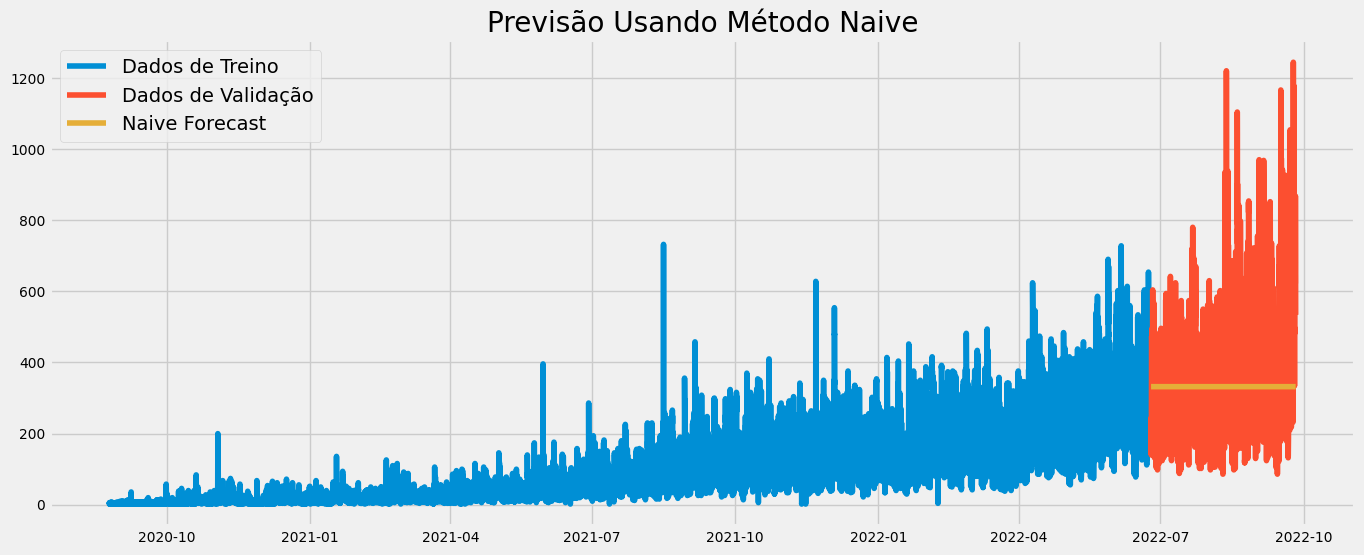

In [44]:
# Plot
figure(figsize = (15, 6))
plt.title("Previsão Usando Método Naive") 
plt.plot(df_treino.index, df_treino['valor_titulo'], label = 'Dados de Treino') 
plt.plot(df_valid.index, df_valid['valor_titulo'], label = 'Dados de Validação') 
plt.plot(df_valid_cp.index, df_valid_cp['previsao_naive'], label = 'Naive Forecast') 
plt.legend(loc = 'best') 
plt.show()

Observe que a linha amarela segue uma linha horizontal, sem considerar o padrão de comportamento da série ao longo do tempo. 

Ou seja, a previsão seria apenas um valor geral considerando o último valor dos dados de treino (dados históricos).

Como sabemos, o valor do título vai sofrer oscilações e é exatamente isso que desejamos prever, para então vender na alta e comprar na baixa, conseguindo algum lucro.

Esse é um método muito simples, mas que serve como ponto de partida. Qualquer técnica mais avançada deve apresentar uma performance melhor.

Então vamos trabalhar para criar um modelo robusto nas próximas aulas. Mas antes, vamos calcular a taxa de erro do modelo.

In [45]:
# Define valor real e valor previsto
y_true = df_valid_cp.valor_titulo
y_pred = df_valid_cp.previsao_naive

In [46]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
# RMSE é a taxa de erro e quanto menor, melhor!
# media do erro quadrático e tira a raiz quadrada
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

195.06210118417584


## Categorias Principais de Algoritmos Para Previsões com Séries Temporais

### 1. Modelos de Regressão de Séries Temporais
O conceito básico é prever a série temporal de interesse \( y \) supondo que ela tenha uma relação linear com outras séries temporais \( x \).  
Por exemplo, podemos desejar prever vendas mensais \( y \) usando o gasto total com publicidade \( x \) como um preditor. Ou podemos prever a demanda diária de eletricidade \( y \) usando temperatura \( x_1 \) e o dia da semana \( x_2 \) como preditores.  
A variável \( y \) às vezes também é chamada de variável regressante, dependente ou explicada. As variáveis preditoras \( x \) às vezes também são chamadas de regressores, variáveis independentes ou explicativas.

### 2. Exponential Smoothing (Suavização Exponencial)
A "suavização exponencial" foi proposta no final da década de 1950 (Brown, 1959; Holt, 1957; Winters, 1960) e motivou alguns dos métodos de previsão mais bem-sucedidos.  
As previsões produzidas usando métodos de suavização exponencial são médias ponderadas de observações passadas, com os pesos decaindo exponencialmente à medida que as observações "envelhecem". Em outras palavras, quanto mais recente a observação, maior o peso associado.  
Essa estrutura gera previsões confiáveis rapidamente e para uma ampla gama de séries temporais, o que é uma grande vantagem e de grande importância para muitas aplicações comerciais.

### 3. Modelos ARIMA (Autoregressive Integrated Moving Average)
Os modelos ARIMA fornecem outra abordagem para a previsão de séries temporais.  
A suavização exponencial e os modelos ARIMA são as duas abordagens mais usadas para previsão de séries temporais e fornecem abordagens complementares. Embora os modelos de suavização exponencial sejam baseados em uma descrição da tendência e da sazonalidade nos dados, os modelos ARIMA visam descrever as correlações automáticas nos dados.  
Modelos ARIMA são técnicas estatísticas avançadas dentro da categoria de Machine Learning.

### 4. Modelos de Regressão Dinâmica
Os modelos de Regressão de Séries Temporais, Exponential Smoothing e ARIMA, permitem a inclusão de informações de observações anteriores de uma série, mas não a inclusão de outras informações que também possam ser relevantes.  
Por exemplo, os efeitos de feriados, atividade da concorrência, mudanças na lei, economia em geral ou outras variáveis externas podem explicar algumas das variações históricas e levar a previsões mais precisas.

### 5. Modelos Hierárquicos ou de Séries Agrupadas
As séries temporais geralmente podem ser desagregadas naturalmente por vários atributos de interesse.  
Por exemplo, o número total de bicicletas vendidas por um fabricante de bicicletas pode ser desagregado por tipo de produto, como bicicletas comuns, mountain bikes, bicicletas infantis e híbridos. Cada um deles pode ser desagregado em categorias mais refinadas.  
Essas categorias são aninhadas nas categorias de grupos maiores e, portanto, a coleção de séries temporais segue uma estrutura de agregação hierárquica.  
Séries temporais hierárquicas geralmente surgem devido a divisões geográficas. Por exemplo, o total de vendas de bicicletas pode ser desagregado por país, depois dentro de cada país por estado, dentro de cada estado por região e assim por diante.

### 6. Métodos Avançados de Previsão de Séries Temporais
Aqui nós temos técnicas de Combinações, Backcasting, Intervalos Para Agregações e Deep Learning (especialmente com modelos LSTM - long Short- Term Memory). Tem a capacidade de capturar padrões complexos e não lineares, além de se adaptar bem a séries multivariadas (várias variáveis dependentes).  


## <font color = darkred> Implementando a Estratégia 2 de Forecasting - Exponential Smoothing </font>

### <font color='darkblue'>Carregando e Explorando os dados </font>

In [47]:
# Carrega os dados
dados_treino = pd.read_csv("dados/dataset_treino.csv")
dados_teste = pd.read_csv("dados/dataset_teste.csv")

In [48]:
# Converte a coluna de data para o tipo correto
dados_treino['data'] = pd.to_datetime(dados_treino.data, format = '%d-%m-%Y %H:%M')

In [49]:
# Converte a coluna de data para o tipo correto
dados_teste['data'] = pd.to_datetime(dados_teste.data, format = '%d-%m-%Y %H:%M')

In [50]:
# Vamos extrair os detalhes da coluna de data: ano, mês, dia e hora
for i in (dados_treino, dados_teste):
    i['ano'] = i.data.dt.year
    i['mes'] = i.data.dt.month
    i['dia'] = i.data.dt.day
    i['hora'] = i.data.dt.hour

In [51]:
# Vamos extrair o dia da semana também
dados_treino['dia_semana'] = dados_treino['data'].dt.dayofweek

In [52]:
# Vejamos como ficou o dataset
dados_treino.head()

,id,data,valor_titulo,ano,mes,dia,hora,dia_semana
0,0,2020-08-25 00:00:00,8,2020,8,25,0,1
1,1,2020-08-25 01:00:00,2,2020,8,25,1,1
2,2,2020-08-25 02:00:00,6,2020,8,25,2,1
3,3,2020-08-25 03:00:00,2,2020,8,25,3,1
4,4,2020-08-25 04:00:00,2,2020,8,25,4,1


In [53]:
# Refinamos os dados para o gráfico da série original

# Definimos o índice do dataset
dados_treino.index = dados_treino['data']

# Removemos a coluna ID, pois ela não é relevante neste caso
features = dados_treino.drop('id', axis = 1)

# A variável Count é nossa variável target (total de pessoas que usaram transporte)
target = dados_treino['valor_titulo']

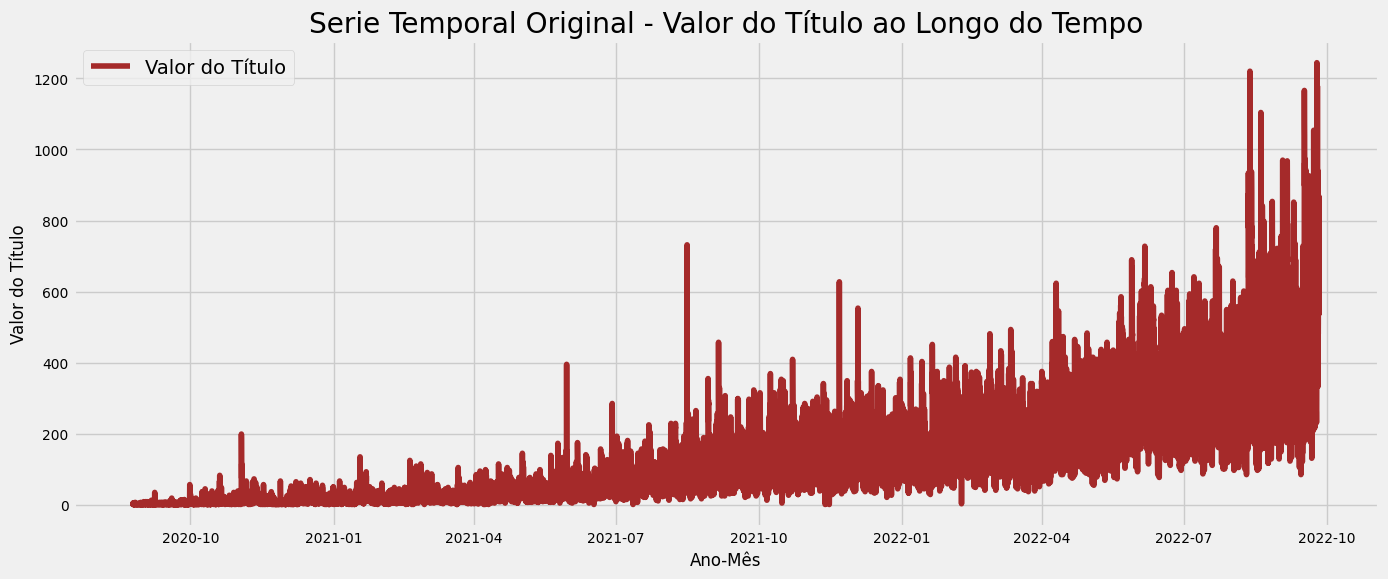

In [54]:
# Plot
figure(figsize = (15, 6))
plt.title("Serie Temporal Original - Valor do Título ao Longo do Tempo")
plt.plot(target, label = "Valor do Título", color = 'brown')
plt.xlabel("Ano-Mês")
plt.ylabel("Valor do Título")
plt.legend(loc = "best")

In [55]:
# Função para testar a estacionaridade
def testa_estacionaridade(serie):
    
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = 12).mean()
    rolstd = serie.rolling(window = 12).std()

    # Plot das estatísticas móveis
    figure(figsize = (15, 6))
    orig = plt.plot(serie, color = 'green', label = 'Original')
    mean = plt.plot(rolmean, color = 'orange', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'blue', label = 'Desvio Padrão')
    
    # Gráfico
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()
    
    # Teste Dickey-Fuller:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Teste
    dfteste = adfuller(serie, autolag = 'AIC')

    # Formatando a saída
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])

    # Loop por cada item da saída do teste
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    # Print
    print (dfsaida)
    
    # Testa o valor-p
    print ('\nConclusão:')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')

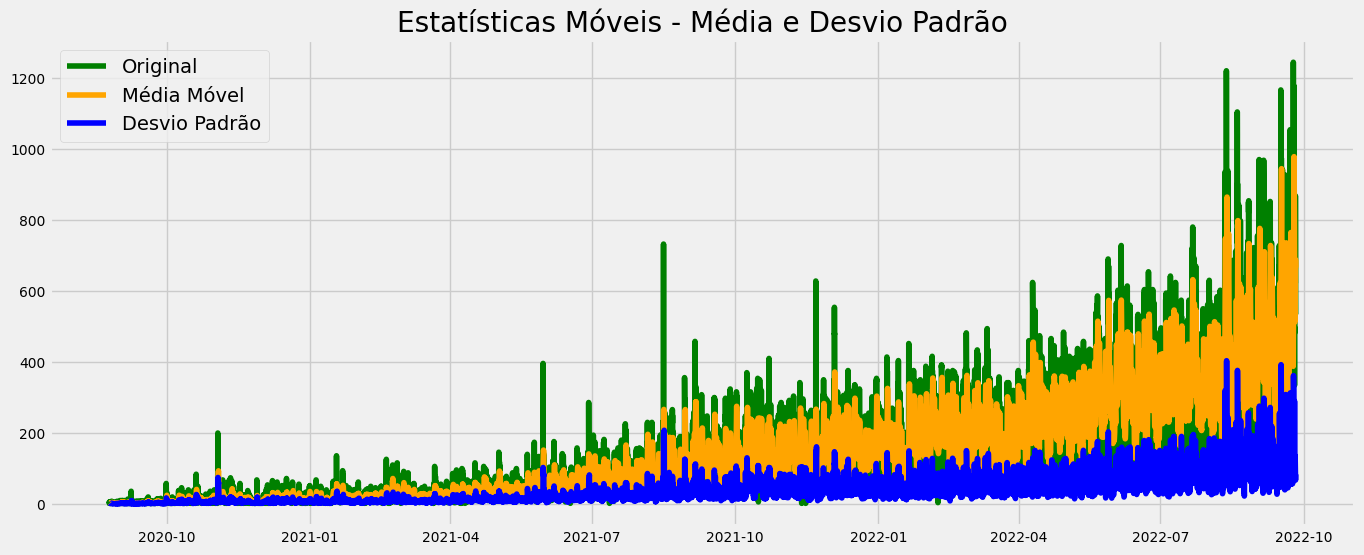


Resultado do Teste Dickey-Fuller:

Estatística do Teste               -4.456561
Valor-p                             0.000235
Número de Lags Consideradas        45.000000
Número de Observações Usadas    18242.000000
Valor Crítico (1%)                 -3.430709
Valor Crítico (5%)                 -2.861698
Valor Crítico (10%)                -2.566854
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [56]:
# Aplica a função 
testa_estacionaridade(dados_treino['valor_titulo'])

In [57]:
# Decompondo a série temporal
decomposition = seasonal_decompose(dados_treino['valor_titulo'])

In [58]:
# Extraindo cada componente da série
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

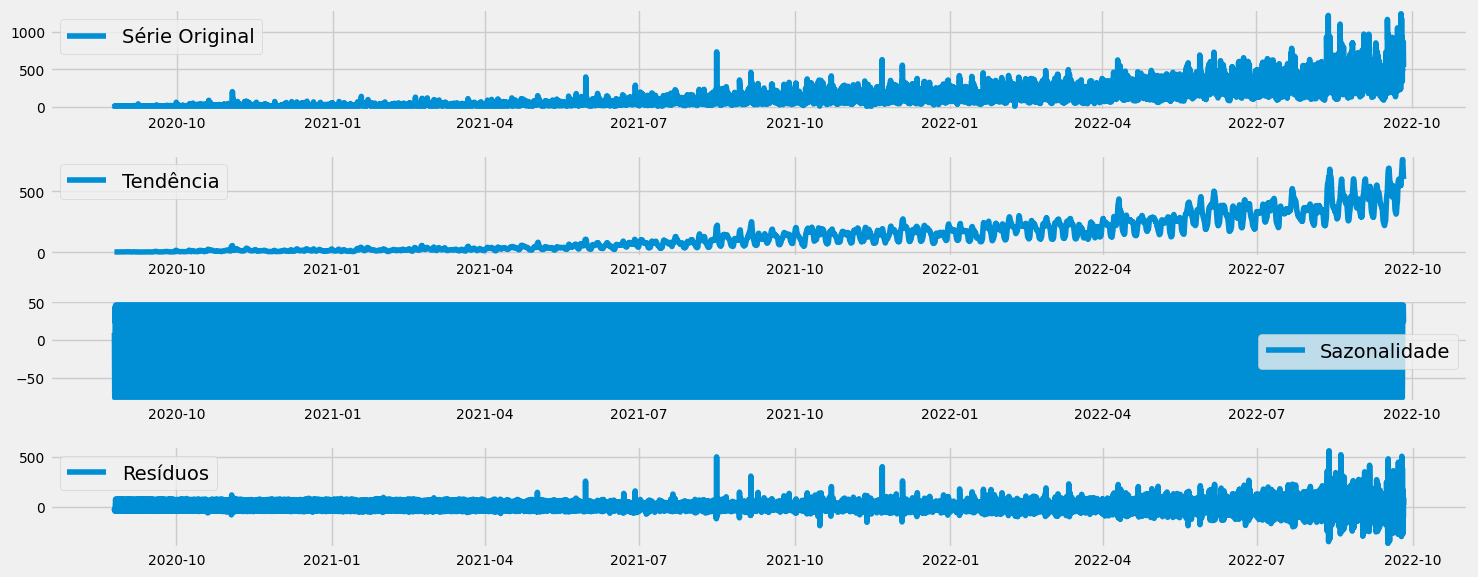

In [59]:
# Plot
figure(figsize = (15, 6))
plt.subplot(411)
plt.plot(dados_treino['valor_titulo'], label = 'Série Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Tendência')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal,label = 'Sazonalidade')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Resíduos')
plt.legend(loc = 'best')
plt.tight_layout()

A série não apresenta sazonalidade, mas percebemos claramente a tendência e algum ruído. 

Dependendo do modelo de previsão usado, a tendência teria que ser removida. Mas como usaremos o **modelo de suavização exponencial**, isso não é necessário, pois esse **modelo trata a tendência** presente na série, como veremos mais abaixo.

Resíduos: O gráfico de resíduos mostra as variações que não foram explicadas pela tendência ou pela sazonalidade. Esses resíduos representam o "ruído" da série. Eles são importantes para avaliar se a série está bem modelada; idealmente, eles devem ser aleatórios e sem padrão visível.


**Suavização Exponencial e a Tendência**
A suavização exponencial é uma técnica usada para prever séries temporais que têm tendência e/ou sazonalidade, aplicando pesos que decaem exponencialmente conforme os dados ficam mais antigos. O método leva em consideração a observação mais recente como a mais importante para a previsão, atribuindo-lhe o maior peso. Isso permite que o método ajuste rapidamente quando há uma tendência presente na série, refletindo as mudanças mais recentes de forma mais precisa.

A  suavização  exponencial  é  um  método  de  previsão  de  séries  temporais  para  dados univariados.

Métodos  de  séries  temporais,  como a  família  de  métodos  Box-Jenkins  ARIMA, desenvolvem um modelo em que a previsão é uma soma linear ponderada de observações ou atrasos (lags) recentes.

Os métodos de previsão de suavização exponencial são semelhantes, pois uma previsão é uma soma ponderadade observações passadas, mas o modelo usa explicitamente um peso decrescente  exponencialmente  para  observações  passadas.  Especificamente,  observações passadas são ponderadas com uma proporção que diminui geometricamente.

As  previsões  produzidas  usando  métodos  de  suavização  exponencial  são  médias ponderadas de observações passadas, com os pesos decaindo exponencialmente à medida que as observações envelhecem. Em outras palavras, quanto mais recente a observação, maior o peso associado.

Os  métodos  de  suavização  exponencial  podem  ser  considerados  uma  alternativa  à popular classe de métodos Box-Jenkins ARIMA para previsão de séries temporais.

Coletivamente,  os  métodos  às  vezes  são  chamados  de  modelos  ETS,  referindo-se  à modelagem explícita de Erro, Tendência e Sazonalidade.

Existem três tipos principais de métodos de previsão de séries temporais de suavização exponencial:

>  Um  método  simples  que  não  assume  estrutura  sistemática,  uma  extensão  que  lida explicitamente  com  as  tendências  e  a  abordagem  mais  avançada  que  adiciona  suporte  à sazonalidade. Vamos definir cada um deles. Suavização Exponencial 

- Simples Suavização exponencial simples, o SES, é um método de previsão de séries temporais para dados univariados sem tendência ou sazonalidade. Requer um único parâmetro, chamado alfa (a), também chamado de fator de suavização ou coeficiente de suavização.Este parâmetro controla a taxa na qual a influência das observações em etapas anteriores decai exponencialmente. Alfa geralmente é definido como um valor entre 0 e 1. Valores grandes significam que o modelo presta atenção principalmente às observações passadas mais recentes, enquanto valores menores significam que mais da história é levada em consideração ao fazer uma previsão. Um valor próximo a 1 indica aprendizado rápido (ou seja, apenas os valores mais recentes influenciam as previsões), enquanto um valor próximo a 0 indica aprendizado lento (observações anteriores têm uma grande influência nas previsões).


- Suavização Exponencial Dupla - A suavização exponencial dupla é uma extensão da suavização exponencial que adiciona explicitamente suporte para tendências na série temporal univariada. Além do parâmetro alfa para controlar o fator de suavização, um fator de suavização adicional é adicionado para controlar a deterioração da influência da mudança na tendência chamada beta (b). 

O  método  suporta  tendências  que  mudam  de  maneiras  diferentes:  um  aditivo  e  um multiplicativo, dependendo se a tendência é linear ou exponencial, respectivamente. 

A suavização exponencial dupla com uma tendência aditiva é classicamente chamada de modelo de tendência linear de Holt, homenagem ao desenvolvedor do método, Charles Holt.

•Tendência aditiva: Suavização exponencial dupla com uma tendência linear.

•Tendência  multiplicativa:  Suavização  exponencial  dupla  com  uma  tendência exponencial.

Para  previsões  de  longo  alcance  (várias  etapas),  a  tendência  pode  continuar irrealisticamente. Como tal, pode ser útil diminuir a tendência ao longo do tempo.

- Suavização Exponencial Tripla - A suavização exponencial tripla é uma extensão da suavização exponencial que adiciona explicitamente suporte àsazonalidade à série temporal univariada. Às  vezes,  esse  método  é  chamado  de  suavização  exponencial  de  Holt-Winters, homenagem aos dois colaboradores do método: Charles Holt e Peter Winters.

Além dos fatores de suavização alfa e beta, é adicionado um novo parâmetro chamado gama (g) que controla ainfluência no componente sazonal.Como na tendência, a sazonalidade pode ser modelada como um processo aditivo ou multiplicativo para uma mudança linear ou exponencial na sazonalidade.

•Sazonalidade aditiva: suavização exponencial tripla com uma sazonalidade linear.

•Sazonalidade  multiplicativa:  Suavização  exponencial  tripla  com  uma  sazonalidade exponencial.


### <font color='darkblue'>Pré-Processamento </font>

Vamos dividir os dados de treino e validação para treinar e validar a performance do modelo antes de usar os dados de teste.

Observe que os registros são separados em ordem cronológica.

In [60]:
# Os dados de treino serão divididos em dados de treino e validação.
df_treino = dados_treino.iloc[0:16057]
df_valid = dados_treino.iloc[16058:]

In [61]:
# Os dados devem estar no formato NumPy para o treino do modelo
array_dados_treino = np.asarray(df_treino['valor_titulo'])

### <font color='darkblue'> Implementação da Estratégia 2 - Suavização Exponencial </font>

Vamos criar dois modelos de Suavização Exponencial usando o Statsmodels.

In [62]:
# Versão 1 do modelo - Simple Exponential Smoothing
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html

# A função SimpleExpSmoothing() recebe os dados de treino no formato de array numpy
# A função fit() faz o treinamento

# O hiperparâmetro smoothing_level define o nível de suavização exponencial na série
# O hiperparâmetro optimized define se teremos ou não otimização 

# Versão 1 do modelo - Simple Exponential Smoothing 
modelo_v1 = SimpleExpSmoothing(array_dados_treino).fit(smoothing_level = 0.2, optimized = True)

In [63]:
# Previsões com o Modelo
df_valid['previsoes_v1'] = modelo_v1.forecast(len(df_valid)) 

In [64]:
# Colocamos lado a lado, valor real e valor "previsto"
df_valid[['valor_titulo', 'previsoes_v1']].head()

,valor_titulo,previsoes_v1
data,,
2022-06-25 02:00:00,218,395.388938
2022-06-25 03:00:00,244,395.388938
2022-06-25 04:00:00,168,395.388938
2022-06-25 05:00:00,140,395.388938
2022-06-25 06:00:00,156,395.388938


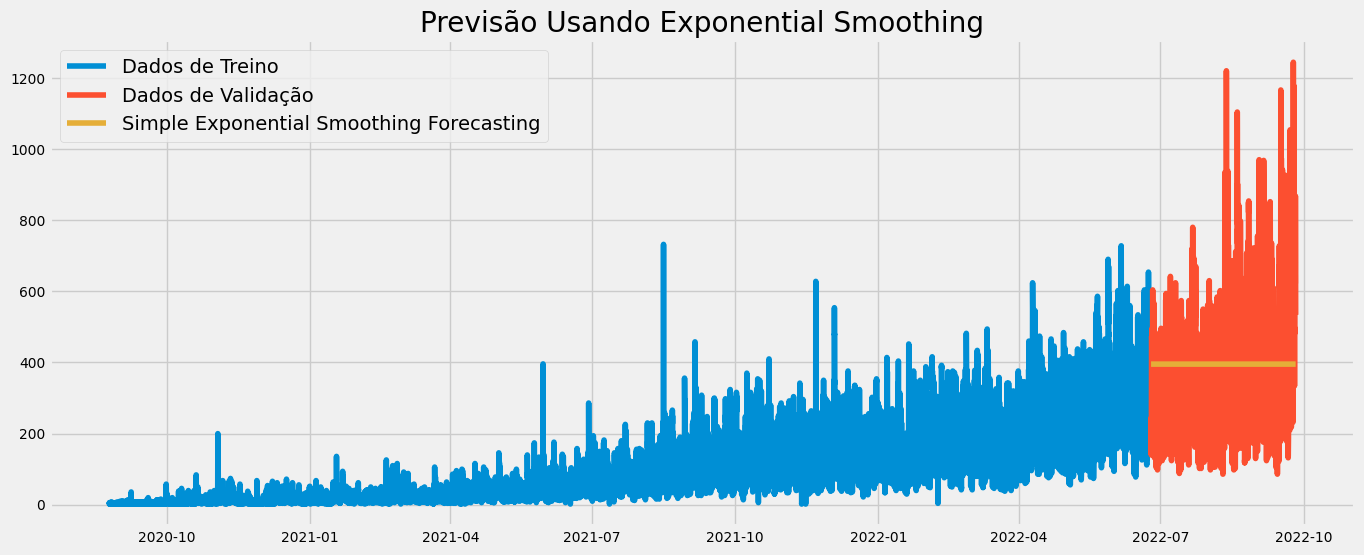

In [65]:
# Plot
figure(figsize = (15, 6))
plt.title("Previsão Usando Exponential Smoothing") 
plt.plot(df_treino['valor_titulo'], label = 'Dados de Treino')
plt.plot(df_valid['valor_titulo'], label = 'Dados de Validação')
plt.plot(df_valid['previsoes_v1'], label = 'Simple Exponential Smoothing Forecasting') 
plt.legend(loc = 'best') 
plt.show()

Visualmente não parece ter tanta diferença para nosso modelo base da Parte 1 do Projeto. Vamos calcular o erro do modelo.

In [66]:
# Define valor real e valor previsto
y_true = df_valid.valor_titulo
y_pred = df_valid.previsoes_v1

In [67]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

186.52867297329848


Nosso modelo base com o Método Naive obteve um RMSE de 195.06. Reduzimos o erro para 186.53. Ou seja, já temos uma forma de fazer previsões um pouco melhores.

Nosso objetivo é reduzir o RMSE tanto quanto possível, pois essa métrica indica a taxa de erro do modelo.

Será que conseguimos melhorar a performance do modelo preditivo? Vamos tentar outro tipo de suavização exponencial.

In [68]:
# Versão 2 do modelo - Double Exponential Smoothing 
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html

# Observe que estamos usando a função ExponentialSmoothing().
# Ao usar o hiperparâmetro trend, definimos o método Double Exponential Smoothing.
# Ao usar o hiperparâmetro seasonal, definimos o método Triple Exponential Smoothing.

# Vamos usar o Double. Como não temos sazonalidade na série, não faz muito sentido usar o Triple.
# Escolhi a série aditiva
# converteu o dataframe do Pandas para array do Numpay no memento da execução dessa vez!
modelo_v2 = ExponentialSmoothing(np.asarray(df_treino['valor_titulo']), 
                                 trend = 'additive').fit(smoothing_level = 0.9, 
                                                         optimized = True) 

In [69]:
# Previsões com o Modelo
df_valid.loc[:,'previsoes_v2'] = modelo_v2.forecast(len(df_valid))

In [70]:
# Colocamos lado a lado, valor real e valor "previsto"
df_valid[['valor_titulo', 'previsoes_v1', 'previsoes_v2']].head()

,valor_titulo,previsoes_v1,previsoes_v2
data,,,
2022-06-25 02:00:00,218,395.388938,337.596236
2022-06-25 03:00:00,244,395.388938,337.681882
2022-06-25 04:00:00,168,395.388938,337.767528
2022-06-25 05:00:00,140,395.388938,337.853174
2022-06-25 06:00:00,156,395.388938,337.938820


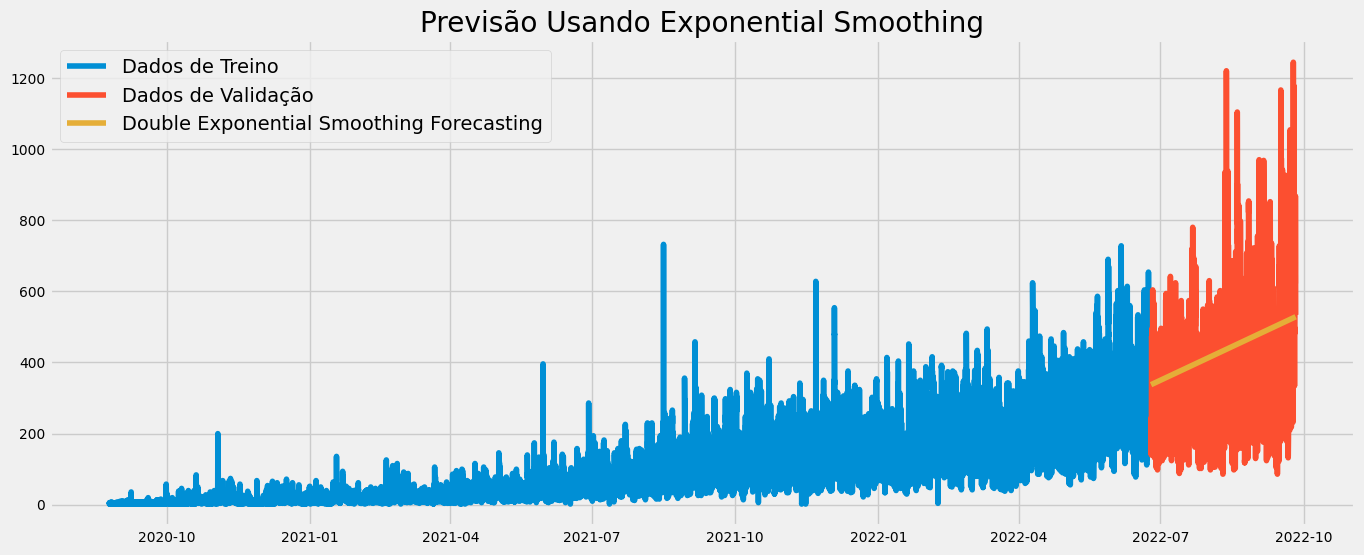

In [71]:
# Plot
figure(figsize = (15, 6))
plt.title("Previsão Usando Exponential Smoothing") 
plt.plot(df_treino['valor_titulo'], label = 'Dados de Treino')
plt.plot(df_valid['valor_titulo'], label = 'Dados de Validação')
plt.plot(df_valid['previsoes_v2'], label = 'Double Exponential Smoothing Forecasting') 
plt.legend(loc = 'best') 
plt.show()

In [72]:
# Define valor real e valor previsto
y_true = df_valid.valor_titulo
y_pred = df_valid.previsoes_v2

In [73]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

182.55380116320066


Agora conseguimos um ganho realmente efetivo. A linha de previsão mudou, seguindo um pouco mais o padrão nos dados, e o erro do modelo caiu um pouco mais.

Ainda assim as técnias de suavização apresentaram um resultado apenas levemente superior ao modelo base. Vamos tentar melhorar isso com outra técnica de Forecasting.

Não usamos ainda os dados de teste, pois esses modelos que estamos estudando até aqui são básicos e temos opções bem mais avançadas que apresentarão resultados bem superiores. E aí sim precisaremos dos dados de teste.